## License 

Copyright 2017 Patrick Hall (phall@h2o.ai) and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#### Python imports 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# h2o
import h2o
h2o.init()

# this LIME package
from lime_xgboost import * 

# enables display of plots in notebook
%matplotlib inline              

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp71eb3l74
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp71eb3l74/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp71eb3l74/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,3 months
H2O cluster name:,H2O_from_python_phall_dnzv33
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Import data and clean

In [2]:
# import XLS file
path = '../data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Create monotone constraints for XGBoost

In [4]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

#### Split data into training and test sets for early stopping

In [5]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier

In [6]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress

[0]	train-auc:0.763478	eval-auc:0.765509
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.771212	eval-auc:0.768848
[2]	train-auc:0.771411	eval-auc:0.767005
[3]	train-auc:0.77285	eval-auc:0.76901
[4]	train-auc:0.773584	eval-auc:0.769504
[5]	train-auc:0.775445	eval-auc:0.77169
[6]	train-auc:0.775442	eval-auc:0.771476
[7]	train-auc:0.775416	eval-auc:0.771288
[8]	train-auc:0.775419	eval-auc:0.771343
[9]	train-auc:0.776108	eval-auc:0.771897
[10]	train-auc:0.777171	eval-auc:0.772864
[11]	train-auc:0.77744	eval-auc:0.77342
[12]	train-auc:0.777984	eval-auc:0.773897
[13]	train-auc:0.77807	eval-auc:0.7739
[14]	train-auc:0.778602	eval-auc:0.774412
[15]	train-auc:0.77884	eval-auc:0.774702
[16]	train-auc:0.779087	eval-auc:0.774935
[17]	train-auc:0.779952	eval-auc:0.77544
[18]	train-auc:0.780322	eval-auc:0.775555
[19]	train-auc:0.780836	eval-auc:0.775873
[20]	train-auc:0.781414	eval-auc:0.7762

####  Display variable importance

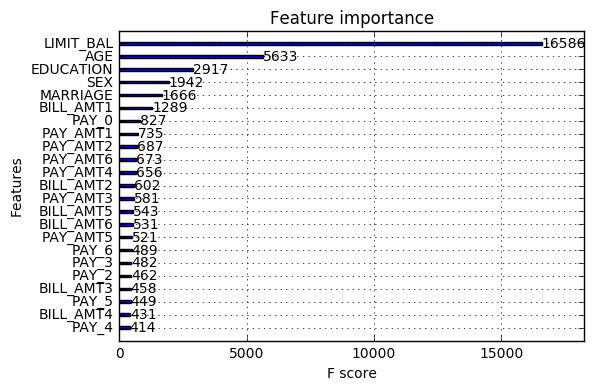

In [7]:
# plot variable importance bar chart
_ = xgb.plot_importance(xgb_model)

#### Explain a prediction with LIME (several example argument combos)


Model Prediction: 0.92
Local GLM Prediction: 0.89
Local GLM R-square: 0.82
Local GLM Intercept: 1.05

Approximate Local Contributions:
        Input  Local Contribution
0         SEX           -0.037843
1         AGE           -0.032428
2   EDUCATION           -0.016780
3       PAY_6           -0.012515
4       PAY_0           -0.011938
5    MARRIAGE           -0.010901
6       PAY_3           -0.010043
7       PAY_2           -0.006969
8       PAY_5           -0.006473
9       PAY_4           -0.006467
10  LIMIT_BAL           -0.002987
11  BILL_AMT5           -0.000691
12  BILL_AMT6           -0.000633
13  BILL_AMT4           -0.000584
14  BILL_AMT2           -0.000556
15   PAY_AMT1           -0.000537
16  BILL_AMT3           -0.000521
17  BILL_AMT1           -0.000429
18   PAY_AMT4           -0.000350
19   PAY_AMT3           -0.000168
None


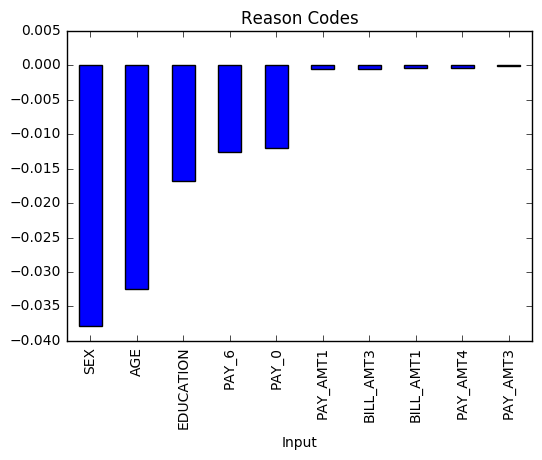

In [8]:
row_id = 20317
explainer = LIMEExplainer(training_frame=train, X=X, model=xgb_model, discretize=None)
explainer.explain(row_id)


Model Prediction: 0.92
Local GLM Prediction: 0.86
Local GLM R-square: 0.95
Local GLM Intercept: 0.92

Approximate Local Contributions:
                   Input  Local Contribution
0   AGE.(58.903, 65.149]           -0.016889
1                  PAY_6           -0.016519
2                  PAY_4           -0.009900
3                  PAY_5           -0.009267
4   PAY_0.(2.988, 3.751]           -0.003934
5                  PAY_3           -0.003136
6   PAY_2.(1.987, 2.796]           -0.000780
7              BILL_AMT5           -0.000749
8              BILL_AMT6           -0.000710
9              BILL_AMT2           -0.000679
10             BILL_AMT4           -0.000652
11              PAY_AMT1           -0.000614
12             BILL_AMT3           -0.000592
13             BILL_AMT1           -0.000550
14              PAY_AMT4           -0.000410
15              PAY_AMT3           -0.000205
None


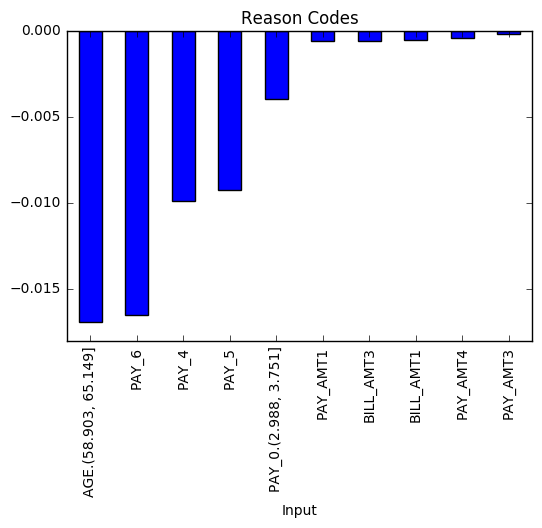

In [9]:
row_id = 20317
explainer = LIMEExplainer(training_frame=train, X=X, model=xgb_model, discretize=['PAY_0', 'PAY_2', 'AGE'])
explainer.explain(row_id)